In [24]:
from numpy import mean
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import tensorflow as tf
from keras import layers, Input, Model
from keras.applications import MobileNet, InceptionV3
import logging, os

#
#  Instructions
#
# This script takes the path of a directory with labeled images of cats and dogs and
# creates a CNN model to classify images of cats/dogs.
#
# Inside the directory taken as input there should be the following:
#  <directory>/train/cat/         - with images of cats used for training
#  <directory>/train/dog/         - with images of dogs used for training
#  <directory>/validation/cat/    - with images of cats used for validation and for testing (50/50)
#  <directory>/validation/dog/    - with images of dogs used for validation and for testing (50/50)
#

logging.disable(logging.WARNING)
logging.disable(logging.INFO)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Definir a seed, para os resultados serem consistentes
tf.keras.utils.set_random_seed(7)

path = input("Enter the path to the images directory: ")

train_path = os.path.join(path, "train")
validation_path = os.path.join(path, "validation")

if not os.path.isdir(path) or not os.path.isdir(train_path) or not os.path.isdir(validation_path):
    sys.exit(f"The directory doesn't exist or it doesn't have the expected structure: {path}.\n"
             f"Please take a look at the instructions comments at the top of the script.")

BATCH_SIZE = 50
IMG_HEIGHT = 100
IMG_WIDTH = 100
EPOCHS = 10

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_and_val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds, test_ds = tf.keras.utils.split_dataset(
    test_and_val_ds, left_size=.5, right_size=.5, shuffle=True
)

# labels inferidas a partir dos nomes dos diretorios
labels = train_ds.class_names
n_labels = len(labels)
print(f"Labels: {labels}")

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Labels: ['cats', 'dogs']


In [25]:
def createModel(preModel: Model = None) -> Model:
    if preModel is None:
        # CNN criada por nós
        model = tf.keras.models.Sequential([
            layers.Rescaling(1. / 255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
            layers.RandomRotation(0.05),
            layers.RandomFlip("horizontal"),
            layers.Conv2D(16, 5, padding='same', activation='relu'),
            layers.Dropout(0.1),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.Dropout(0.1),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 2, padding='same', activation='relu'),
            layers.Dropout(0.2),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(n_labels, activation="softmax")
        ])
    else:
        # Rede pré-treinada
        model = tf.keras.models.Sequential([
            layers.Rescaling(1. / 255, offset=-1, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
            preModel,
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(n_labels, activation="softmax")
        ])
    
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    
    model.summary()
    
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)
    
    # evolucao da loss e acertos
    plt.figure(2, figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # matriz de confusao para os dados de validação
    y_pred_val = model.predict(val_ds)
    y_pred_val = tf.argmax(y_pred_val, axis=1)
    y_true_val = tf.concat([y for x, y in val_ds], axis=0)
    y_true_val = tf.argmax(y_true_val, axis=1)
    cm_val = confusion_matrix(y_true_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Validation Set')
    plt.show()
    
    # matriz de confusao para os dados de teste
    y_pred_test = model.predict(test_ds)
    y_pred_test = tf.argmax(y_pred_test, axis=1)
    y_true_test = tf.concat([y for x, y in test_ds], axis=0)
    y_true_test = tf.argmax(y_true_test, axis=1)
    cm_test = confusion_matrix(y_true_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Test Set')
    plt.show()
    
    # Dar print da melhor accuracy para os dados de teste
    best_val_accuracy = max(history.history['val_accuracy'])
    mean_val_accuracy = mean(history.history['val_accuracy'])
    print(f"Melhor taxa de acertos (conjunto de validação): {(best_val_accuracy * 100):.2f}%")
    print(f"Média taxa de acertos (conjunto de validação): {(mean_val_accuracy * 100):.2f}%")
    
    return model

In [26]:
inceptionV3 = InceptionV3(input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)), include_top=False)
inceptionV3.summary()
# Importante! Assinalar que não se pretende treinar os pesos do modelo importado
inceptionV3.trainable = False

mobileNetModel = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
mobileNetModel.summary()
# Importante! Assinalar que não se pretende treinar os pesos do modelo importado
mobileNetModel.trainable = False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_382 (Conv2D)         (None, 49, 49, 32)           864       ['input_13[0][0]']            
                                                                                                  
 batch_normalization_376 (B  (None, 49, 49, 32)           96        ['conv2d_382[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 49, 49, 32)           0         ['batch_normalizati

## Com a nossa CNN (Sem transferência de conhecimento)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 100, 100, 3)       0         
 otation)                                                        
                                                                 
 random_flip_2 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 conv2d_476 (Conv2D)         (None, 100, 100, 16)      1216      
                                                                 
 dropout_6 (Dropout)         (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 50, 50, 16)        0         
 ng2D)                                               

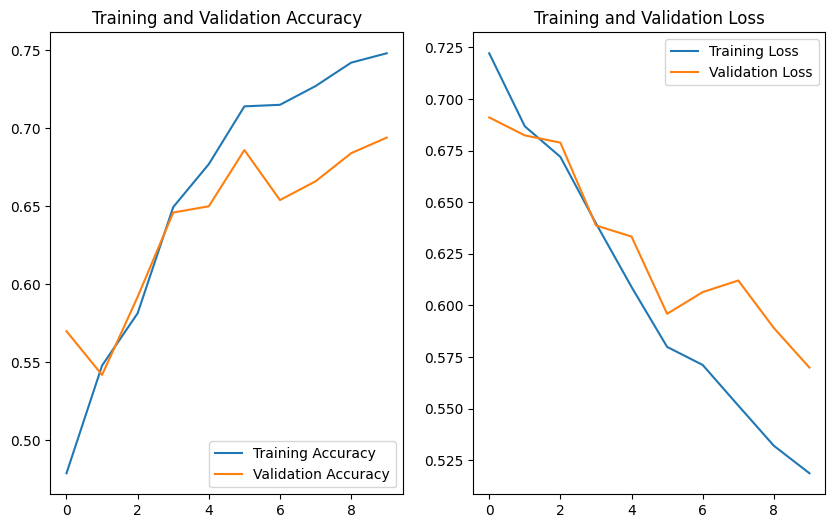

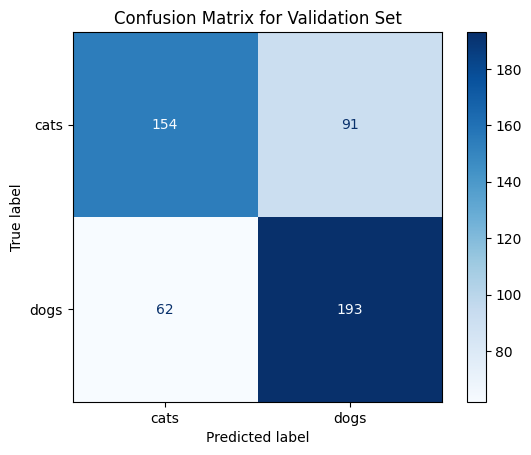

10/10 [==============================] - 0s 19ms/step


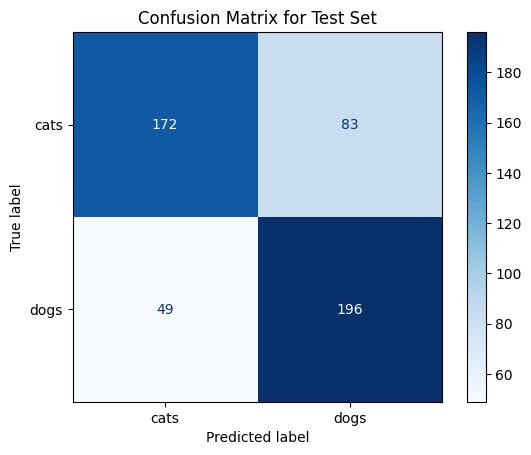

Melhor taxa de acertos (conjunto de validação): 69.40%
Média taxa de acertos (conjunto de validação): 63.84%


In [27]:
createModel()

## Com transferência de conhecimento: InceptionV3

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               524544    
                                                                 
 dense_31 (Dense)            (None, 2)                 514       
                                                                 
Total params: 22327842 (85.17 MB)
Trainable params: 525058 (2.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1/

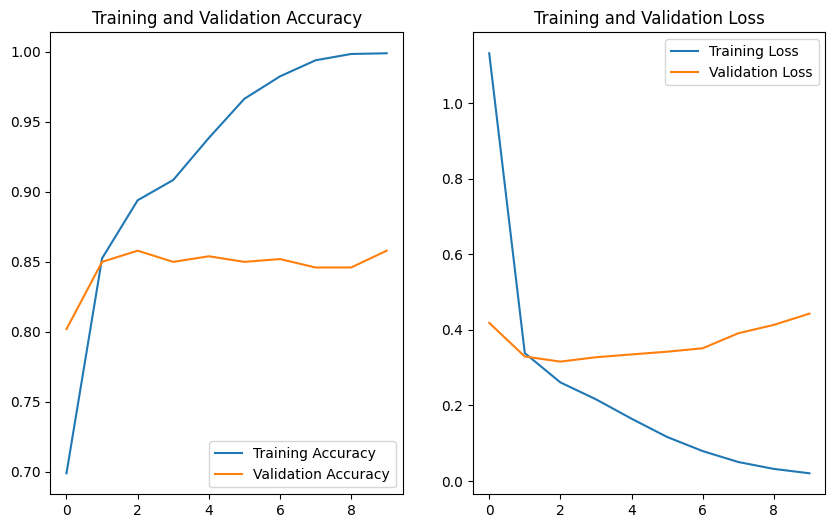

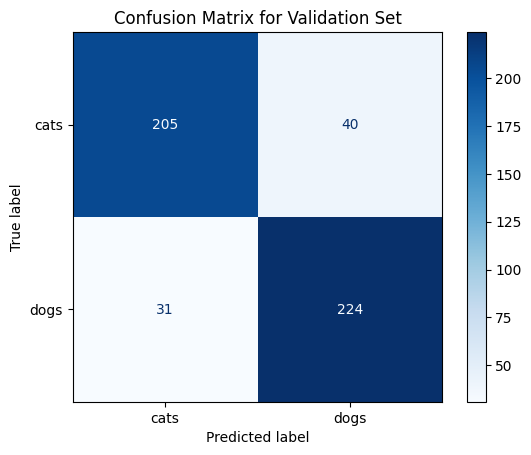

10/10 [==============================] - 1s 87ms/step


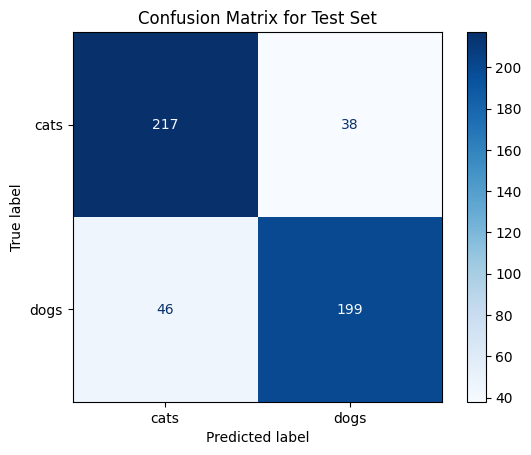

Melhor taxa de acertos (conjunto de validação): 85.80%
Média taxa de acertos (conjunto de validação): 84.66%


In [28]:
createModel(inceptionV3)

## Com transferência de conhecimento: MobileNet

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 3, 3, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 9216)              0         
                                                                 
 dense_32 (Dense)            (None, 256)               2359552   
                                                                 
 dense_33 (Dense)            (None, 2)                 514       
                                                                 
Total params: 5588930 (21.32 MB)
Trainable params: 2360066 (9.00 MB)
Non-trainable params: 3228864 (12.32 MB)
_________

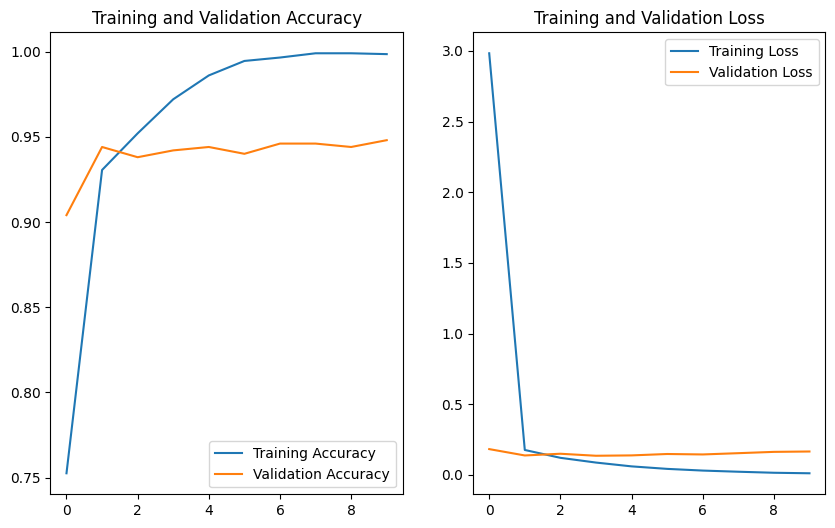

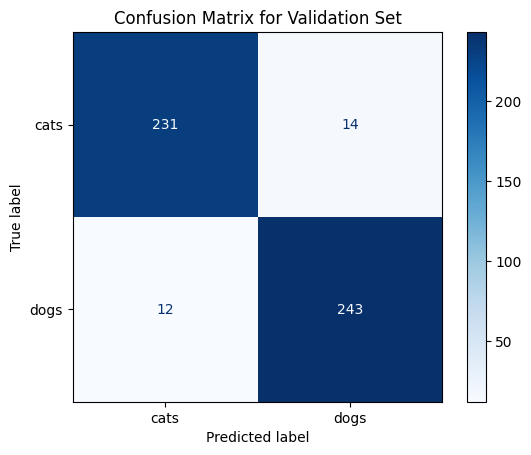

10/10 [==============================] - 0s 47ms/step


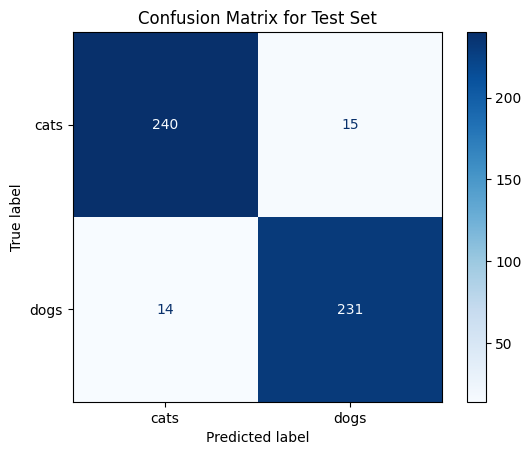

Melhor taxa de acertos (conjunto de validação): 94.80%
Média taxa de acertos (conjunto de validação): 93.96%


In [29]:
createModel(mobileNetModel)

## Racional utilizado na escolha dos modelos

>A escolha dos modelos foi focada sobretudo no seu desempenho enquanto modelo pré-treinado, quer a nível de eficiência computacional, quer a nível da precisão (accuracy). Sendo o objetivo melhorar a performance do nosso modelo com um modelo pré-treinado, minimizando desta forma a exigência de performance computacional que seria necessária para obter um resultado equivalente sem o uso dessa ferramenta. 

>Inception e MobileNet são redes neurais convolucionais frequentemente utilizadas em tarefas de classificação de imagens, cada uma abordando desafios específicos relacionados com a eficiência computacional e precisão.
A Inception foi desenvolvida com o objetivo de reduzir a exigência computacional usualmente necessária na utilização de DNNs., mantendo um elevado desempenho mesmo com redes mais profundas. Normalmente, o aumento da complexidade faz-se custo da eficiência computacional, mas o Inception consegue realizar transformações em paralelo do mesmo input. Para cada layer,  utiliza convoluções de 5x5, 3x3 e max pooling. Fá-lo com recurso a redução da dimensionalidade para minimizar o impacto no desempenho computacional. 

>O MobileNet é uma arquitetura de Rede Neural Convolucional (CNN) projetada para dispositivos móveis, também conhecida pela sua eficiência no desempenho computacional. 
Na primeira camada, o MobileNet utiliza uma convolução regular, mas camadas subsequentes empregam convoluções separáveis em profundidade. A convolução em profundidade opera em cada canal de forma independente, reduzindo a exigência computacional. A convolução ponto a ponto, semelhante à convolução regular com um filtro de 1x1, funde os canais de saída da convolução em profundidade para criar novas características, aumentando a eficiência computacional em comparação com redes convolucionais tradicionais.

>Tanto o Inception como o MobileNet têm o seu foco principal na eficiência computacional
  


>**Sources**: 
> 1. Listio, Syntia. (2022). Performance of Deep Learning Inception Model and MobileNet Model on Gender Prediction Through Eye Image. Sinkron. 7. 2593-2601. 10.33395/sinkron.v7i4.11887.

> 2.Howard, Andrew & Zhu, Menglong & Chen, Bo & Kalenichenko, Dmitry & Wang, Weijun & Weyand, Tobias & Andreetto, Marco & Adam, Hartwig. (2017). MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications. 

> 3. Advanced Guide to Inception v3, https://cloud.google.com/tpu/docs/inception-v3-advanced, last accessed on 2023-11-05

## Resultados e conclusão

>Ao utilizar transferência de conhecimentos de modelos pré-treinados, conseguimos alcançar um aumento substancial na taxa de acertos do algoritmo. Comparando a melhor taxa de acertos no conjunto de validação, com a nossa CNN alcançámos os 69.40%. Com transferência de conhecimentos conseguimos 85.80% com a rede InceptionV3, e 94.80% com a rede MobileNet. Obtemos então um aumento de cerca de 25% na taxa de acertos.